In [29]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#SQLITE 
import sqlite3
import pandas as pd
from sqlite3 import Error

#NLTK
from nltk.corpus import stopwords

In [30]:
#!/usr/bin/python

  
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def select_all_chats(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    cur = conn.cursor()
    cur.execute("SELECT * FROM chats limit 2")
 
    rows = cur.fetchall()
 
    for row in rows:
        print(row)

def select_chat_by_room_uri(conn, room_uri):
    """
    Query chat by room_uri
    :param conn: the Connection object
    :param room_uri:
    :return:
    """
    cur = conn.cursor()
    cur.execute("SELECT * FROM chats WHERE room_uri=? limit 10", (room_uri,))
 
    rows = cur.fetchall()
 
    for row in rows:
        print(row)


In [31]:
 
#def main():
database = "../database/chat.db"

# create a database connection
conn = create_connection(database)
with conn:
    print("1. Query task by room_uri:")
    #select_chat_by_room_uri(conn,'FreeCodeCamp/python')

    print("2. Query all tasks")
    select_all_chats(conn)
    
    print("Chat.DB converted into dataframe")
    chat_df = pd.read_sql_query("SELECT * FROM chats limit 90000", conn)


1. Query task by room_uri:
2. Query all tasks
(1, '56d558f5e610378809c460cd', 'FreeCodeCamp/python', '2016-12-24T11:21:22.947Z', '585a9e6fd73408ce4f3e86bb', 'Aleksandar1', '585e5a32e7bdfe4e2992db54', 'so dose anyone here is willing to help me learn how to work in Python , some advice or some practice would be helpful , l am beginer didnt work with any other lenguage , so l get Python on colage and l need help :worried: ')
(2, '56d558f5e610378809c460cd', 'FreeCodeCamp/python', '2016-12-23T22:11:15.028Z', '55e0b0bc0fc9f982beaeef0d', 'teichopsia-', '585da103c02c1a3959a6ee57', "In short, it's an indentation problem you are having. Check the setting in idle. Insert spaces instead of tabs if not set. Or, hit the spacebar four times at the proper indentation blocks. ")
Chat.DB converted into dataframe


In [32]:
#pprint(chat_df.room_uri.unique())

In [33]:
chat_df.head()

,chat_id,room_id,room_uri,sent_at,from_userid,from_username,message_id,text
0,1,56d558f5e610378809c460cd,FreeCodeCamp/python,2016-12-24T11:21:22.947Z,585a9e6fd73408ce4f3e86bb,Aleksandar1,585e5a32e7bdfe4e2992db54,so dose anyone here is willing to help me lear...
1,2,56d558f5e610378809c460cd,FreeCodeCamp/python,2016-12-23T22:11:15.028Z,55e0b0bc0fc9f982beaeef0d,teichopsia-,585da103c02c1a3959a6ee57,"In short, it's an indentation problem you are ..."
2,3,56d558f5e610378809c460cd,FreeCodeCamp/python,2016-12-23T22:04:44.171Z,55e0b0bc0fc9f982beaeef0d,teichopsia-,585d9f7c0730ce693702a180,"@Atalaa I don't use idle, but a few things com..."
3,4,56d558f5e610378809c460cd,FreeCodeCamp/python,2016-12-23T01:42:08.552Z,5750fefcc43b8c6019767b1f,Atalaa,585c80f0c5a4e0233bbd3642,i just wanna write it with good indentation be...
4,5,56d558f5e610378809c460cd,FreeCodeCamp/python,2016-12-23T01:26:32.057Z,580a396bd73408ce4f2fdd1e,mstellaluna,585c7d48af6b364a29e81038,I'm not sure aata.. they could be just 2 diffe...


In [34]:
print("length of original data",len(chat_df))
analysis_df=chat_df[['chat_id','text']]
analysis_df=analysis_df[['text']].dropna()
print("length of distinct data",len(analysis_df))
print("shape of data",analysis_df.shape)

length of original data 90000
length of distinct data 89649
shape of data (89649, 1)


In [35]:
analysis_df.shape

(89649, 1)

In [36]:
analysis_df.head()

,text
0,so dose anyone here is willing to help me lear...
1,"In short, it's an indentation problem you are ..."
2,"@Atalaa I don't use idle, but a few things com..."
3,i just wanna write it with good indentation be...
4,I'm not sure aata.. they could be just 2 diffe...


In [37]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','https','http','.png'])

### Remove emails and newline characters

In [38]:
# Convert to list
data = analysis_df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', text) for text in data]

# Remove new line characters
data = [re.sub('\s+', ' ', text) for text in data]

# Remove distracting single quotes
data = [re.sub("\'", "", text) for text in data]

pprint(data[:1])

['so dose anyone here is willing to help me learn how to work in Python , some '
 'advice or some practice would be helpful , l am beginer didnt work with any '
 'other lenguage , so l get Python on colage and l need help :worried: ']


### Tokenize words and Clean-up text

In [39]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['so', 'dose', 'anyone', 'here', 'is', 'willing', 'to', 'help', 'me', 'learn', 'how', 'to', 'work', 'in', 'python', 'some', 'advice', 'or', 'some', 'practice', 'would', 'be', 'helpful', 'am', 'beginer', 'didnt', 'work', 'with', 'any', 'other', 'lenguage', 'so', 'get', 'python', 'on', 'colage', 'and', 'need', 'help', 'worried']]


### Creating bi-gram model

In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])
print(bigram_mod[data_words[0]])

['so', 'dose', 'anyone', 'here', 'is', 'willing', 'to', 'help', 'me', 'learn', 'how', 'to', 'work', 'in', 'python', 'some', 'advice', 'or', 'some', 'practice', 'would', 'be', 'helpful', 'am', 'beginer', 'didnt', 'work', 'with', 'any', 'other', 'lenguage', 'so', 'get', 'python', 'on', 'colage', 'and', 'need', 'help', 'worried']


### Remove Stopwords, Make Bigrams and Lemmatize

In [41]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['dose', 'anyone', 'willing', 'help', 'learn', 'work', 'python', 'advice', 'practice', 'would', 'helpful', 'beginer', 'do', 'not', 'work', 'lenguage', 'get', 'python', 'colage', 'nee', 'help', 'worried']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

print(id2word[0])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 1), (18, 1)]]
advice


In [44]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advice', 1),
  ('anyone', 1),
  ('beginer', 1),
  ('colage', 1),
  ('do', 1),
  ('dose', 1),
  ('get', 1),
  ('help', 2),
  ('helpful', 1),
  ('learn', 1),
  ('lenguage', 1),
  ('nee', 1),
  ('not', 1),
  ('practice', 1),
  ('python', 2),
  ('willing', 1),
  ('work', 2),
  ('worried', 1),
  ('would', 1)]]

### Building the Topic Model

In [45]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [46]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"be" + 0.029*"not" + 0.029*"git" + 0.024*"do" + 0.019*"issue" + '
  '0.019*"pull" + 0.018*"work" + 0.017*"make" + 0.014*"need" + 0.013*"would"'),
 (1,
  '0.204*"wiki" + 0.150*"freecodecamp" + 0.144*"com" + 0.109*"github" + '
  '0.040*"article" + 0.038*"www" + 0.016*"rafase" + 0.015*"md" + '
  '0.011*"remote" + 0.009*"star"'),
 (2,
  '0.032*"file" + 0.030*"check" + 0.026*"fix" + 0.022*"request" + 0.019*"take" '
  '+ 0.019*"s" + 0.017*"home" + 0.017*"back" + 0.017*"right" + 0.016*"npm"'),
 (3,
  '0.047*"change" + 0.038*"get" + 0.032*"go" + 0.030*"thank" + 0.027*"merge" + '
  '0.025*"update" + 0.024*"new" + 0.024*"link" + 0.021*"time" + 0.020*"ill"'),
 (4,
  '0.065*"label" + 0.064*"add" + 0.056*"sparkle" + 0.042*"point" + '
  '0.041*"also" + 0.030*"thumbsup" + 0.025*"sends_brownie" + 0.021*"title" + '
  '0.020*"gitter" + 0.014*"array"')]


### Compute Model Perplexity and Coherence Score

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.125939210439173

Coherence Score:  0.3822268398788566


### Model Vsualization

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      41.808491        1       1  0.256096  0.290975
2      21.312483        1       2  0.063222 -0.140573
3      17.153214        1       3  0.110322 -0.128685
4      10.674527        1       4 -0.071797 -0.206977
1       9.051284        1       5 -0.357843  0.185259, topic_info=      Category          Freq             Term         Total  loglift  logprob
term                                                                         
473    Default  11397.000000             wiki  11397.000000  30.0000  30.0000
96     Default   8386.000000     freecodecamp   8386.000000  29.0000  29.0000
140    Default   8072.000000              com   8072.000000  28.0000  28.0000
259    Default   6113.000000           github   6113.000000  27.0000  27.0000
5545   Default   4298.000000            label   4298.000000  26.0000  26.0000
368    Default   4239.000000              add   4239.000000  25.0000  25.0000
34     Default   4998.000000           change   4998.000000  24.0000  24.0000
276    Default   3669.000000          sparkle   3669.000000  23.0000  23.0000
6      Default   4004.000000              get   4004.000000  22.0000  22.0000
75     Default   7623.000000               be   7623.000000  21.0000  21.0000
12     Default   7520.000000              not   7520.000000  20.0000  20.0000
1066   Default   7507.000000              git   7507.000000  19.0000  19.0000
484    Default   4174.000000             file   4174.000000  18.0000  18.0000
274    Default   2800.000000            point   2800.000000  17.0000  17.0000
20     Default   3949.000000            check   3949.000000  16.0000  16.0000
443    Default   2675.000000             also   2675.000000  15.0000  15.0000
69     Default   3383.000000               go   3383.000000  14.0000  14.0000
248    Default   3180.000000            thank   3180.000000  13.0000  13.0000
4      Default   6267.000000               do   6267.000000  12.0000  12.0000
764    Default   2251.000000          article   2251.000000  11.0000  11.0000
264    Default   3448.000000              fix   3448.000000  10.0000  10.0000
146    Default   2119.000000              www   2119.000000   9.0000   9.0000
2208   Default   2854.000000            merge   2854.000000   8.0000   8.0000
725    Default   2693.000000           update   2693.000000   7.0000   7.0000
207    Default   2590.000000              new   2590.000000   6.0000   6.0000
529    Default   2935.000000          request   2935.000000   5.0000   5.0000
512    Default   2561.000000             link   2561.000000   4.0000   4.0000
277    Default   1947.000000         thumbsup   1947.000000   3.0000   3.0000
365    Default   4948.000000            issue   4948.000000   2.0000   2.0000
1658   Default   4945.000000             pull   4945.000000   1.0000   1.0000
...        ...           ...              ...           ...      ...      ...
1977    Topic5    614.692688           remote    615.918457   2.4003  -4.5103
4354    Topic5    495.815552             star    496.952179   2.4000  -4.7252
106     Topic5    445.972046              png    447.108124   2.3997  -4.8311
95      Topic5    441.606293     files_gitter    442.741119   2.3997  -4.8410
278     Topic5    410.582764           cookie    411.719604   2.3995  -4.9138
244     Topic5    339.329010             idea    340.505585   2.3988  -5.1044
4035    Topic5    307.445099        camperbot    308.602570   2.3985  -5.2031
105     Topic5    302.766205            image    303.916229   2.3985  -5.2184
1598    Topic5    296.219482             blob    297.356567   2.3984  -5.2403
197     Topic5    314.732452             tell    315.946716   2.3984  -5.1797
787     Topic5    288.910980           delete    290.082428   2.3982  -5.2653
1574    Topic5    837.973145               md    841.445374   2.3981  -4.2004
3922    Topic5    263.997040      point_right    265.160034   2.3979 

In [49]:
### Building LDA Mallet model

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = r'/Users/annandi/WorkDocs/GeorgiaTech/10_project/mallet-2.0.8/'
mallet_path = r'/Users/annandi/WorkDocs/GeorgiaTech/10_project/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [51]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('freecodecamp', 0.0862026257121625),
   ('www', 0.07164411016281216),
   ('github', 0.03347445222600041),
   ('wiki', 0.024061521832143582),
   ('add', 0.022012295358839824),
   ('git', 0.01945639201026865),
   ('change', 0.018375481343031505),
   ('check', 0.01684419123111221),
   ('star', 0.016123584119620782),
   ('cookie', 0.015628166730470423)]),
 (1,
  [('js', 0.037194873562498044),
   ('file', 0.034938739698555446),
   ('npm', 0.028911937663856944),
   ('node', 0.02492192314521773),
   ('server', 0.02147505196419432),
   ('run', 0.01878022540448511),
   ('error', 0.017088125006528166),
   ('err', 0.01630474519265921),
   ('call', 0.014257512612415004),
   ('module', 0.013630808761319838)]),
 (2,
  [('sparkle', 0.060803633980428935),
   ('point', 0.041029175800583066),
   ('thumbsup', 0.031367940518429796),
   ('sends_brownie', 0.029774684173653643),
   ('good', 0.02418133743135438),
   ('time', 0.02120951885918326),
   ('thing', 0.019006079233429004),
   ('stream', 0.01

### How to find the optimal number of topics for LDA?

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=30, step=5)

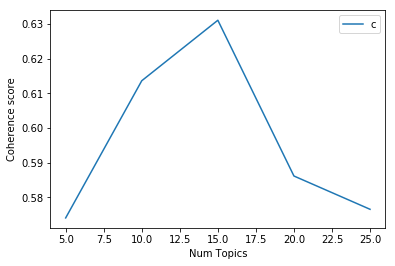

In [54]:
# Show graph
limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### It's evident from the chart above that our model performed best when we have generated 20 topics. Hence, I will consider 20 topics in our final model

In [55]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5741
Num Topics = 10  has Coherence Value of 0.6136
Num Topics = 15  has Coherence Value of 0.631
Num Topics = 20  has Coherence Value of 0.5862
Num Topics = 25  has Coherence Value of 0.5766


In [56]:
# Final Model
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.108*"app" + 0.056*"heroku" + 0.055*"run" + 0.052*"server" + 0.046*"start" '
  '+ 0.045*"error" + 0.039*"web" + 0.023*"database" + 0.022*"mongo" + '
  '0.021*"code"'),
 (1,
  '0.049*"stream" + 0.036*"ill" + 0.025*"people" + 0.023*"give" + 0.020*"free" '
  '+ 0.019*"bit" + 0.018*"fcc" + 0.014*"files_gitter" + 0.014*"watch" + '
  '0.013*"wait"'),
 (2,
  '0.104*"js" + 0.081*"npm" + 0.069*"node" + 0.046*"err" + 0.038*"module" + '
  '0.029*"test" + 0.029*"package" + 0.027*"error" + 0.022*"install" + '
  '0.021*"workspace"'),
 (3,
  '0.076*"project" + 0.046*"react" + 0.044*"work" + 0.039*"back" + '
  '0.026*"challenge" + 0.025*"end" + 0.022*"show" + 0.022*"build" + '
  '0.022*"page" + 0.019*"check"'),
 (4,
  '0.084*"user" + 0.041*"poll" + 0.035*"option" + 0.026*"return" + '
  '0.024*"array" + 0.023*"string" + 0.023*"vote" + 0.019*"number" + '
  '0.018*"store" + 0.018*"object"'),
 (5,
  '0.067*"good" + 0.041*"learn" + 0.038*"thing" + 0.035*"make" + 0.034*"stuff" '
  '+ 0.030*"tutoria

In [57]:
# Visualize the topics
pyLDAvis.enable_notebook()
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
12     7.978870        1       1 -0.250414  0.015078
2      7.439809        1       2 -0.173345  0.027961
10     7.109266        1       3 -0.244736 -0.007650
14     6.980209        1       4 -0.048492  0.013438
4      6.956911        1       5 -0.024207  0.114144
0      6.810511        1       6 -0.237247  0.000850
13     6.710334        1       7  0.059395  0.121299
7      6.557979        1       8  0.044482  0.018789
8      6.370024        1       9  0.129187  0.200717
3      6.359556        1      10  0.145696  0.101257
5      6.341248        1      11  0.125998 -0.021156
1      6.273924        1      12  0.131278 -0.100053
11     6.240683        1      13  0.199558  0.090058
9      6.070065        1      14  0.063184 -0.319056
6      5.800612        1      15  0.079664 -0.255676, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
96     Default  10479.000000    freecodecamp  10479.000000  30.0000  30.0000
146    Default   8712.000000             www   8712.000000  29.0000  29.0000
276    Default   7173.000000         sparkle   7173.000000  28.0000  28.0000
339    Default   5740.000000        function   5740.000000  27.0000  27.0000
543    Default   6839.000000             app   6839.000000  26.0000  26.0000
274    Default   4840.000000           point   4840.000000  25.0000  25.0000
440    Default   4764.000000              js   4764.000000  24.0000  24.0000
484    Default   4453.000000            file   4453.000000  23.0000  23.0000
16     Default   6458.000000            work   6458.000000  22.0000  22.0000
277    Default   3700.000000        thumbsup   3700.000000  21.0000  21.0000
259    Default   3863.000000          github   3863.000000  20.0000  20.0000
275    Default   3512.000000   sends_brownie   3512.000000  19.0000  19.0000
2141   Default   3824.000000             url   3824.000000  18.0000  18.0000
5072   Default   3703.000000             npm   3703.000000  17.0000  17.0000
1402   Default   3591.000000            user   3591.000000  16.0000  16.0000
192    Default   4643.000000            code   4643.000000  15.0000  15.0000
2648   Default   4695.000000             err   4695.000000  14.0000  14.0000
1138   Default   4329.000000             var   4329.000000  13.0000  13.0000
934    Default   3192.000000            node   3192.000000  12.0000  12.0000
562    Default   3127.000000         project   3127.000000  11.0000  11.0000
1023   Default   2876.000000             api   2876.000000  10.0000  10.0000
473    Default   2776.000000            wiki   2776.000000   9.0000   9.0000
70     Default   2739.000000            good   2739.000000   8.0000   8.0000
33     Default   2474.000000            time   2474.000000   7.0000   7.0000
517    Default   3053.000000          server   3053.000000   6.0000   6.0000
3275   Default   2347.000000          heroku   2347.000000   5.0000   5.0000
39     Default   3915.000000           error   3915.000000   4.0000   4.0000
116    Default   3728.000000            make   3728.000000   3.0000   3.0000
1134   Default   2354.000000         express   2354.000000   2.0000   2.0000
216    Default   2431.000000             run   2431.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
724    Topic15    335.945631           smile    335.945631   2.8472  -4.6695
1408   Topic15    325.280690              xd    325.280690   2.8472  -4.7017
308    Topic15    266.623516             yea    266.623516   2.8472  -4.9006
3438   Topic15    246.626753           stock    246.626753   2.8472  -4.9786
1376   Topic15    203.966990         testing    203.966990   2.8472  -5.1685
540    Topic15    195.968285         warning    195.968285   2.8472  -5.2085
5128   Topic15    190.635814           ankur    190.6

### Finding the dominant topic in each sentence

In [58]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Chat_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Chat Text']

# Show
df_dominant_topic.head(10)

,Document_No,Chat_Topic,Topic_Perc_Contrib,Keywords,Chat Text
0,0,5.0,0.0990,"good, learn, thing, make, stuff, tutorial, und...",so dose anyone here is willing to help me lear...
1,1,7.0,0.1431,"code, python, question, write, read, variable,...","In short, its an indentation problem you are h..."
2,2,11.0,0.1765,"work, time, find, problem, nice, figure, thing...","I dont use idle, but a few things come to mind..."
3,3,7.0,0.0952,"code, python, question, write, read, variable,...",i just wanna write it with good indentation be...
4,4,7.0,0.0833,"code, python, question, write, read, variable,...",Im not sure aata.. they could be just 2 differ...
5,5,5.0,0.0860,"good, learn, thing, make, stuff, tutorial, und...","yes, its important to keep an open mind"
6,6,11.0,0.0833,"work, time, find, problem, nice, figure, thing...",even with else it dont indent with the if wtf
7,7,7.0,0.0818,"code, python, question, write, read, variable,...",Im not sure as to why its not printing nor why...
8,8,7.0,0.1384,"code, python, question, write, read, variable,...",i havent come across double if statements in m...
9,9,7.0,0.0970,"code, python, question, write, read, variable,...",Plus why i cannot read it like in the tutorial...


In [65]:
df_dominant_topic.head()

,Document_No,Chat_Topic,Topic_Perc_Contrib,Keywords,Chat Text
0,0,5.0,0.0990,"good, learn, thing, make, stuff, tutorial, und...",so dose anyone here is willing to help me lear...
1,1,7.0,0.1431,"code, python, question, write, read, variable,...","In short, its an indentation problem you are h..."
2,2,11.0,0.1765,"work, time, find, problem, nice, figure, thing...","I dont use idle, but a few things come to mind..."
3,3,7.0,0.0952,"code, python, question, write, read, variable,...",i just wanna write it with good indentation be...
4,4,7.0,0.0833,"code, python, question, write, read, variable,...",Im not sure aata.. they could be just 2 differ...


In [83]:
dominant_topic_text_df = chat_df.join(df_dominant_topic)
columns_to_keep = ["chat_id","room_id","room_uri","sent_at","from_userid","message_id","text","Chat_Topic","Keywords"]
final_dominant_topic_text_df = dominant_topic_text_df[columns_to_keep]
final_dominant_topic_text_df.to_csv("final_dominant_topic_text_df.txt",sep='\t')

In [72]:
final_dominant_topic_text_df.to_tsv("final_dominant_topic_text_df.txt")

###  Find the most representative document for each topic

In [59]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7711,"app, heroku, run, server, start, error, web, d...",``` 2016-03-14T19:46:00.645322+00:00 app[web.1...
1,1.0,0.5307,"stream, ill, people, give, free, bit, fcc, fil...",def blendThreeSounds(): file1=pickAFile() file...
2,2.0,0.7501,"js, npm, node, err, module, test, package, err...","Hello Every one, Can any one please help me ou..."
3,3.0,0.4846,"project, react, work, back, challenge, end, sh...",example of the output: ``` Apple MacBook Air 2...
4,4.0,0.6263,"user, poll, option, return, array, string, vot...","``` 1. ACTUAL: ""[ Lets throw a smoko piece of ..."


In [76]:
sent_topics_sorteddf_mallet.to_csv("most_representative_chat_for_each_topic.txt",sep = '\t')

### Topic distribution across documents

In [60]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(5)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,5.0,"good, learn, thing, make, stuff, tutorial, und...",16712.0,0.1864
1,7.0,"code, python, question, write, read, variable,...",7852.0,0.0876
2,11.0,"work, time, find, problem, nice, figure, thing...",4165.0,0.0465
3,7.0,"code, python, question, write, read, variable,...",6142.0,0.0685
4,7.0,"code, python, question, write, read, variable,...",5088.0,0.0568


In [77]:
len(df_dominant_topics)

89649

In [79]:
#df_dominant_topics

In [61]:
df_dominant_topics.head(15)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,5.0,"good, learn, thing, make, stuff, tutorial, und...",16712.0,0.1864
1,7.0,"code, python, question, write, read, variable,...",7852.0,0.0876
2,11.0,"work, time, find, problem, nice, figure, thing...",4165.0,0.0465
3,7.0,"code, python, question, write, read, variable,...",6142.0,0.0685
4,7.0,"code, python, question, write, read, variable,...",5088.0,0.0568
5,5.0,"good, learn, thing, make, stuff, tutorial, und...",6909.0,0.0771
6,11.0,"work, time, find, problem, nice, figure, thing...",6130.0,0.0684
7,7.0,"code, python, question, write, read, variable,...",4945.0,0.0552
8,7.0,"code, python, question, write, read, variable,...",4913.0,0.0548
9,7.0,"code, python, question, write, read, variable,...",3838.0,0.0428


## Expeiments in the bewlo sections

In [62]:
df = pd.DataFrame({
    'col1' : ['A', 'A', 'B', np.nan, 'D', 'C'],
    'col2' : [2, 1, 9, 8, 7, 4],
    'col3': [0, 1, 9, 4, 2, 3],
     })

In [63]:
df

,col1,col2,col3
0,A,2,0
1,A,1,1
2,B,9,9
3,NaN,8,4
4,D,7,2
5,C,4,3


In [64]:
df.sort_values(by=['col2'], ascending=False)

,col1,col2,col3
2,B,9,9
3,NaN,8,4
4,D,7,2
5,C,4,3
0,A,2,0
1,A,1,1
